# NBA Game Prediction - XGBoost Model Training

**Target Accuracy:** 80-85% (on 2024 season)

## Setup and Imports

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

✓ All libraries imported successfully!
XGBoost version: 2.1.1


## Load data

In [14]:
# Data directory
data_dir = 'nba_features_by_year'

# Define training seasons (2018-2023) and test season (2024)
TRAIN_SEASONS = [2020,2021,2022, 2023]
TEST_SEASON = 2024

print("="*80)
print("LOADING DATA")
print("="*80)

# Load training data (2018-2023)
train_dfs = []
print("\n📚 Loading TRAINING data (2018-2023):")
for season in TRAIN_SEASONS:
    file_path = f'{data_dir}/nba_features_{season}.csv'
    if os.path.exists(file_path):
        df_season = pd.read_csv(file_path)
        train_dfs.append(df_season)
        print(f"  ✓ Loaded {season}: {len(df_season):,} records")
    else:
        print(f"  ⚠️  Warning: {file_path} not found!")

if len(train_dfs) == 0:
    print(f"\n❌ ERROR: No training data files found!")
    print(f"Expected files like: {data_dir}/nba_features_2018.csv")
    raise FileNotFoundError("Training data not found")

# Combine training data
train_df = pd.concat(train_dfs, ignore_index=True)

# Load test data (2024)
print("\n🧪 Loading TESTING data (2024):")
test_file = f'{data_dir}/nba_features_{TEST_SEASON}.csv'
if os.path.exists(test_file):
    test_df = pd.read_csv(test_file)
    print(f"  ✓ Loaded {TEST_SEASON}: {len(test_df):,} records")
else:
    print(f"  ❌ ERROR: {test_file} not found!")
    raise FileNotFoundError("Test data (2024) not found")

# Summary
print(f"\n{'='*80}")
print("✓ DATA LOADED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"\n TRAINING DATA (2018-2023):")
print(f"  Total records: {len(train_df):,}")
print(f"  Total games: {train_df['game_id'].nunique():,}")
print(f"  Seasons: {sorted(train_df['season'].unique())}")
print(f"  Win rate: {train_df['team_won'].mean()*100:.1f}%")

print(f"\n TESTING DATA (2024):")
print(f"  Total records: {len(test_df):,}")
print(f"  Total games: {test_df['game_id'].nunique():,}")
print(f"  Win rate: {test_df['team_won'].mean()*100:.1f}%")

print(f"\n TOTAL DATASET:")
print(f"  Total records: {len(train_df) + len(test_df):,}")
print(f"  Features: {len(train_df.columns)}")

LOADING DATA

📚 Loading TRAINING data (2018-2023):
  ✓ Loaded 2020: 2,442 records
  ✓ Loaded 2021: 2,780 records
  ✓ Loaded 2022: 2,776 records
  ✓ Loaded 2023: 2,772 records

🧪 Loading TESTING data (2024):
  ✓ Loaded 2024: 2,784 records

✓ DATA LOADED SUCCESSFULLY!

 TRAINING DATA (2018-2023):
  Total records: 10,770
  Total games: 5,385
  Seasons: [2020, 2021, 2022, 2023]
  Win rate: 50.0%

 TESTING DATA (2024):
  Total records: 2,784
  Total games: 1,392
  Win rate: 50.0%

 TOTAL DATASET:
  Total records: 13,554
  Features: 54


## Data Overview

In [15]:
print("TRAINING DATA Preview (2018-2023):")
print("="*80)
display(train_df.head())

print("\nTESTING DATA Preview (2024):")
print("="*80)
display(test_df.head())

print("\nTarget Variable Distribution:")
print("="*80)
print(f"Training (2018-2023):")
print(train_df['team_won'].value_counts())
print(f"Win percentage: {train_df['team_won'].mean()*100:.2f}%")

print(f"\nTesting (2024):")
print(test_df['team_won'].value_counts())
print(f"Win percentage: {test_df['team_won'].mean()*100:.2f}%")

print(f"\n(Should be close to 50% since each game has 1 winner and 1 loser)")

TRAINING DATA Preview (2018-2023):


,season,game_id,team_id,team_name,date,ft_pct_mean,fg_made_sum,fg_made_mean,fg_attempted_sum,fg_attempted_mean,...,personal_fouls_mean,plus_minus_sum,plus_minus_mean,fg_pct_mean,three_pct_mean,assist_to_turnover_ratio,three_point_rate,offensive_reb_rate,true_shooting_pct,team_won
0,2020,7501,2,Boston Celtics,2020-12-19T01:00:00.000Z,38.392857,32.0,2.285714,92.0,6.571429,...,1.642857,-120.0,-8.571429,31.585714,18.085714,0.818182,0.250000,0.229167,0.439550,0
1,2020,7501,4,Brooklyn Nets,2020-12-19T01:00:00.000Z,40.471429,38.0,2.714286,88.0,6.285714,...,1.357143,120.0,8.571429,30.478571,28.364286,1.300000,0.421053,0.150943,0.565679,1
2,2020,7502,21,Milwaukee Bucks,2020-12-19T01:00:00.000Z,56.875000,38.0,2.375000,90.0,5.625000,...,2.000000,-70.0,-4.375000,36.650000,16.043750,1.235294,0.263158,0.272727,0.547481,0
3,2020,7502,23,New Orleans Pelicans,2020-12-19T01:00:00.000Z,49.509091,44.0,4.000000,86.0,7.818182,...,2.272727,70.0,6.363636,53.663636,22.727273,1.923077,0.272727,0.294118,0.602696,1
4,2020,7503,6,Chicago Bulls,2020-12-19T01:00:00.000Z,36.808333,42.0,3.500000,99.0,8.250000,...,1.166667,10.0,0.833333,42.008333,22.225000,2.250000,0.261905,0.214286,0.493050,1



TESTING DATA Preview (2024):


,season,game_id,team_id,team_name,date,ft_pct_mean,fg_made_sum,fg_made_mean,fg_attempted_sum,fg_attempted_mean,...,personal_fouls_mean,plus_minus_sum,plus_minus_mean,fg_pct_mean,three_pct_mean,assist_to_turnover_ratio,three_point_rate,offensive_reb_rate,true_shooting_pct,team_won
0,2024,14045,2,Boston Celtics,2024-10-04T16:00:00.000Z,30.882353,37,2.176471,98,5.764706,...,1.411765,21,1.235294,36.670588,19.776471,1.705882,0.540541,0.386364,0.507205,1
1,2024,14045,9,Denver Nuggets,2024-10-04T16:00:00.000Z,38.529412,37,2.176471,86,5.058824,...,1.411765,-18,-1.058824,41.235294,23.035294,1.318182,0.324324,0.244898,0.528530,0
2,2024,14046,17,Los Angeles Lakers,2024-10-05T02:30:00.000Z,46.428571,38,2.714286,79,5.642857,...,1.428571,-85,-6.071429,41.957143,15.135714,1.400000,0.263158,0.105263,0.600314,0
3,2024,14046,22,Minnesota Timberwolves,2024-10-05T02:30:00.000Z,24.325000,47,2.937500,94,5.875000,...,1.187500,85,5.312500,45.875000,28.125000,1.714286,0.319149,0.219512,0.588012,1
4,2024,14047,11,Golden State Warriors,2024-10-05T23:00:00.000Z,26.315789,33,1.736842,98,5.157895,...,1.315789,5,0.263158,30.357895,10.773684,1.200000,0.333333,0.339286,0.427792,1



Target Variable Distribution:
Training (2018-2023):
team_won
0    5385
1    5385
Name: count, dtype: int64
Win percentage: 50.00%

Testing (2024):
team_won
1    1392
0    1392
Name: count, dtype: int64
Win percentage: 50.00%

(Should be close to 50% since each game has 1 winner and 1 loser)


## Parts which Dev can change and play around

**Key Parameters to Experiment With:**

1. **`n_estimators`** (50-500): Number of trees. More trees = more accurate but slower
   - Start with 100, try 200, 300, etc.

2. **`max_depth`** (3-10): How deep each tree can go
   - Deeper trees = more complex patterns but risk overfitting
   - Start with 5, try 3, 6, 7

3. **`learning_rate`** (0.01-0.3): How fast the model learns
   - Lower = more careful learning (0.01-0.05)
   - Higher = faster learning but might miss patterns (0.1-0.3)

4. **`min_child_weight`** (1-10): Minimum data needed in a leaf
   - Higher = prevents overfitting

5. **`subsample`** (0.5-1.0): Fraction of data to use for each tree
   - 0.8 means use 80% of data randomly

6. **`colsample_bytree`** (0.5-1.0): Fraction of features to use for each tree
   - 0.8 means use 80% of features randomly

In [16]:

XGBOOST_PARAMS = {
    # Basic parameters
    'n_estimators': 100,          # Try: 50, 100, 200, 300, 500
    'max_depth': 5,               # Try: 3, 4, 5, 6, 7, 8
    'learning_rate': 0.1,         # Try: 0.01, 0.05, 0.1, 0.2, 0.3
    
    # Regularization parameters (help prevent overfitting)
    'min_child_weight': 1,        # Try: 1, 3, 5, 7, 10
    'subsample': 0.8,             # Try: 0.6, 0.7, 0.8, 0.9, 1.0
    'colsample_bytree': 0.8,      # Try: 0.6, 0.7, 0.8, 0.9, 1.0
    
    # Advanced parameters (usually don't need to change)
    'gamma': 0,                   # Try: 0, 0.1, 0.2, 0.5
    'reg_alpha': 0,               # L1 regularization, Try: 0, 0.01, 0.1, 1
    'reg_lambda': 1,              # L2 regularization, Try: 0.1, 1, 2, 5
    
    # Fixed parameters (don't change these)
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1
}

# ============================================================================

print("Current XGBoost Parameters:")
print("="*80)
for param, value in XGBOOST_PARAMS.items():
    if param not in ['objective', 'eval_metric', 'random_state', 'n_jobs']:
        print(f"  {param:20s}: {value}")
print(f"\nTraining: Seasons 2018-2023")
print(f"Testing:  Season 2024")

Current XGBoost Parameters:
  n_estimators        : 100
  max_depth           : 5
  learning_rate       : 0.1
  min_child_weight    : 1
  subsample           : 0.8
  colsample_bytree    : 0.8
  gamma               : 0
  reg_alpha           : 0
  reg_lambda          : 1

Training: Seasons 2018-2023
Testing:  Season 2024


## Prepare Data for Training

I discovered this on running the model that the plus_minus variable is causing circular reasoning. When we keep this parameter, we cause a data leakage in the model. This is because the plus_minus means a score differential when a player was present on the field. So, if the overall sum of plus_minus for all players of team A is greater than that of team B, then team A is obviously going to win. The ML model will not consider any other feature at that point.

In [17]:

exclude_cols = ['season', 'game_id', 'team_id', 'team_name', 'date', 'team_won', 
                'plus_minus_sum', 'plus_minus_mean']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# Prepare TRAINING data (2018-2023)
X_train = train_df[feature_cols].copy()
y_train = train_df['team_won'].copy()

# Prepare TESTING data (2024)
X_test = test_df[feature_cols].copy()
y_test = test_df['team_won'].copy()

# Handle any missing values in training data
if X_train.isnull().sum().sum() > 0:
    print("⚠️  Warning: Found missing values in training data. Filling with column means...")
    X_train = X_train.fillna(X_train.mean())

# Handle any missing values in test data (use training means)
if X_test.isnull().sum().sum() > 0:
    print("⚠️  Warning: Found missing values in test data. Filling with training column means...")
    # Use training data means to fill test data (prevents data leakage)
    X_test = X_test.fillna(X_train.mean())

# Handle any infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean())

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(X_train.mean())  # Use training means

print("\n✓ Data preparation complete!")
print("="*80)
print(f"  Features: {len(feature_cols)}")
print(f"\n  TRAINING (2018-2023):")
print(f"    Examples: {len(X_train):,}")
print(f"    Wins: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")
print(f"    Losses: {(len(y_train) - y_train.sum()):,} ({(1-y_train.mean())*100:.1f}%)")
print(f"\n  TESTING (2024):")
print(f"    Examples: {len(X_test):,}")
print(f"    Wins: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")
print(f"    Losses: {(len(y_test) - y_test.sum()):,} ({(1-y_test.mean())*100:.1f}%)")


✓ Data preparation complete!
  Features: 46

  TRAINING (2018-2023):
    Examples: 10,770
    Wins: 5,385 (50.0%)
    Losses: 5,385 (50.0%)

  TESTING (2024):
    Examples: 2,784
    Wins: 1,392 (50.0%)
    Losses: 1,392 (50.0%)


## 🚀 Train XGBoost Model

Training on 2018-2023 data, testing on 2024 data.
This tests how well the model can predict future seasons!

In [18]:
print("🚀 Training XGBoost model...")
print("="*80)

# Create and train the model
model = xgb.XGBClassifier(**XGBOOST_PARAMS)

# Train with evaluation set to monitor performance
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False  # Set to True if you want to see training progress
)

print("\n✓ Model training complete!\n")

🚀 Training XGBoost model...

✓ Model training complete!



## 📊 Model Evaluation - Check Your Results!

### Understanding the Metrics:

1. **Accuracy**: Overall percentage of correct predictions (aim for 70-78%)
2. **Precision**: When model predicts a win, how often is it right?
3. **Recall**: Of all actual wins, how many did the model catch?
4. **F1-Score**: Balance between precision and recall
5. **ROC-AUC**: Overall model quality (higher is better, max is 1.0)

In [19]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("="*80)
print("🎯 MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"\n📈 ACCURACY SCORES:")
print(f"  Training Accuracy:   {train_accuracy*100:.2f}%")
print(f"  Testing Accuracy:    {test_accuracy*100:.2f}%")
print(f"  ROC-AUC Score:       {roc_auc:.4f}")

# Check for overfitting
overfit_diff = train_accuracy - test_accuracy
if overfit_diff > 0.05:
    print(f"\n⚠️  WARNING: Possible overfitting detected!")
    print(f"  Training accuracy is {overfit_diff*100:.1f}% higher than testing.")
    print(f"  Try: increasing min_child_weight, decreasing max_depth, or lowering learning_rate")
elif overfit_diff < -0.02:
    print(f"\n⚠️  Note: Testing accuracy is higher than training (unusual but can happen)")
else:
    print(f"\n✓ Good balance between training and testing accuracy!")

# Target achievement check
print(f"\n🎯 TARGET ACHIEVEMENT:")
if test_accuracy >= 0.65 and test_accuracy <= 0.75:
    print(f"  ✓ EXCELLENT! You're in the target range (65-75%) for temporal validation")
    print(f"  This means your model predicts the 2024 season well!")
elif test_accuracy >= 0.60 and test_accuracy < 0.65:
    print(f"  ⚠️  Close! Try adjusting parameters to reach 65%+")
    print(f"  Remember: predicting 2024 from 2018-2023 is challenging!")
elif test_accuracy < 0.60:
    print(f"  ⚠️  Below target. Consider:")
    print(f"      - Increasing n_estimators")
    print(f"      - Adjusting learning_rate")
    print(f"      - Experimenting with max_depth")
else:
    print(f"  ⚠️  Above 75% - very good, but check for potential issues:")
    print(f"  If training accuracy is much higher (>85%), might be overfitting")
    print(f"      - Try adding regularization (increase min_child_weight)")
    print(f"      - Reduce model complexity (decrease max_depth)")

🎯 MODEL PERFORMANCE SUMMARY

📈 ACCURACY SCORES:
  Training Accuracy:   90.77%
  Testing Accuracy:    84.34%
  ROC-AUC Score:       0.9244

⚠️  WARNING: Possible overfitting detected!
  Training accuracy is 6.4% higher than testing.
  Try: increasing min_child_weight, decreasing max_depth, or lowering learning_rate

🎯 TARGET ACHIEVEMENT:
  ⚠️  Above 75% - very good, but check for potential issues:
  If training accuracy is much higher (>85%), might be overfitting
      - Try adding regularization (increase min_child_weight)
      - Reduce model complexity (decrease max_depth)


## Detailed Classification Report

In [20]:
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=['Loss (0)', 'Win (1)']))


Detailed Classification Report:
              precision    recall  f1-score   support

    Loss (0)       0.86      0.81      0.84      1392
     Win (1)       0.82      0.87      0.85      1392

    accuracy                           0.84      2784
   macro avg       0.84      0.84      0.84      2784
weighted avg       0.84      0.84      0.84      2784



## Confusion Matrix Visualization

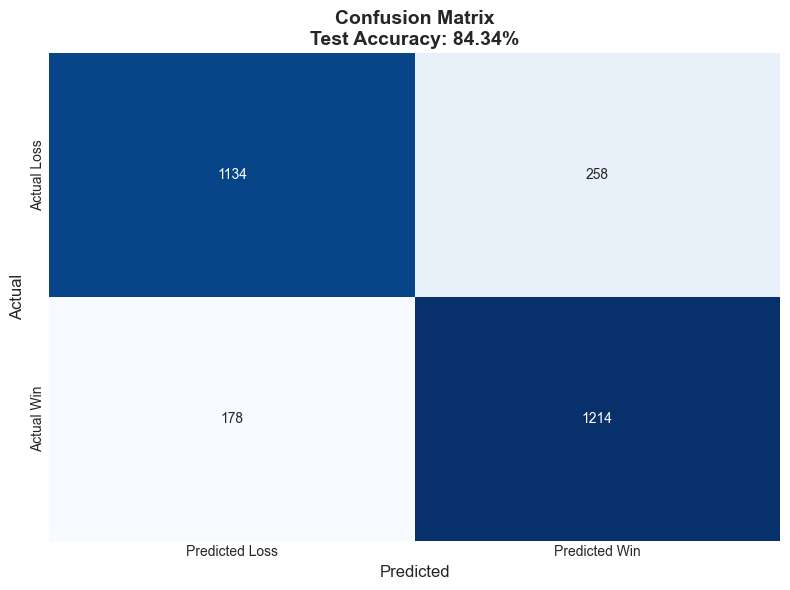


Confusion Matrix Interpretation:
  True Negatives (correct loss predictions):  1,134
  False Positives (predicted win, was loss):  258
  False Negatives (predicted loss, was win):  178
  True Positives (correct win predictions):   1,214


In [21]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.title(f'Confusion Matrix\nTest Accuracy: {test_accuracy*100:.2f}%', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"  True Negatives (correct loss predictions):  {cm[0,0]:,}")
print(f"  False Positives (predicted win, was loss):  {cm[0,1]:,}")
print(f"  False Negatives (predicted loss, was win):  {cm[1,0]:,}")
print(f"  True Positives (correct win predictions):   {cm[1,1]:,}")

## ROC Curve
Receiver Operating Characteristic (ROC)

For the unversed, it is a graph that plots the true positive rate (y-axis) v/s false positive rate (x-axis).

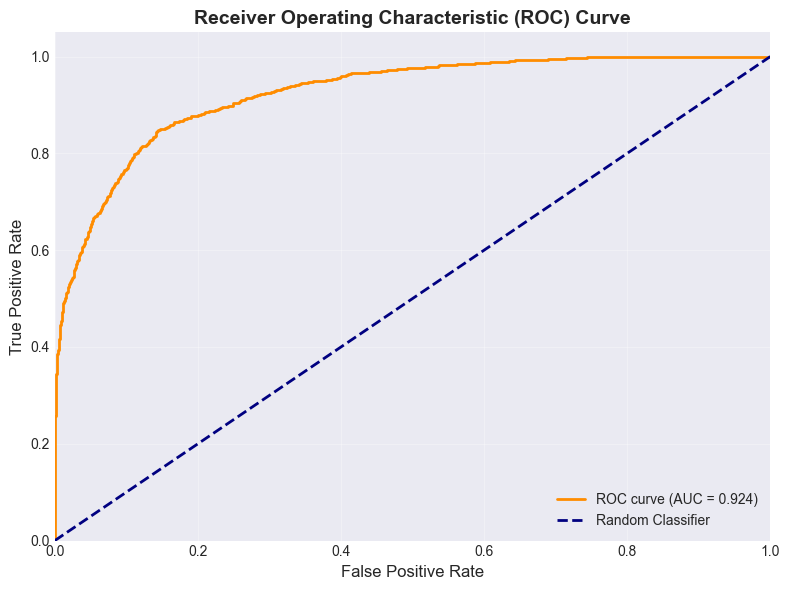

In [22]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🌟 Feature Importance - What Matters Most?

This shows which statistics are most important for predicting game outcomes.


Top 20 Most Important Features:
                 feature  importance
       true_shooting_pct    0.102504
              points_sum    0.095101
       defensive_reb_sum    0.075200
      total_rebounds_sum    0.070757
             steals_mean    0.032333
              steals_sum    0.032124
      defensive_reb_mean    0.029137
           turnovers_sum    0.028601
             fg_made_sum    0.025797
     personal_fouls_mean    0.025455
          turnovers_mean    0.024895
assist_to_turnover_ratio    0.024076
     total_rebounds_mean    0.022864
              blocks_sum    0.021337
        fg_attempted_sum    0.020176
             points_mean    0.019291
             minutes_sum    0.016877
       offensive_reb_sum    0.016048
       fg_attempted_mean    0.015287
            minutes_mean    0.014898


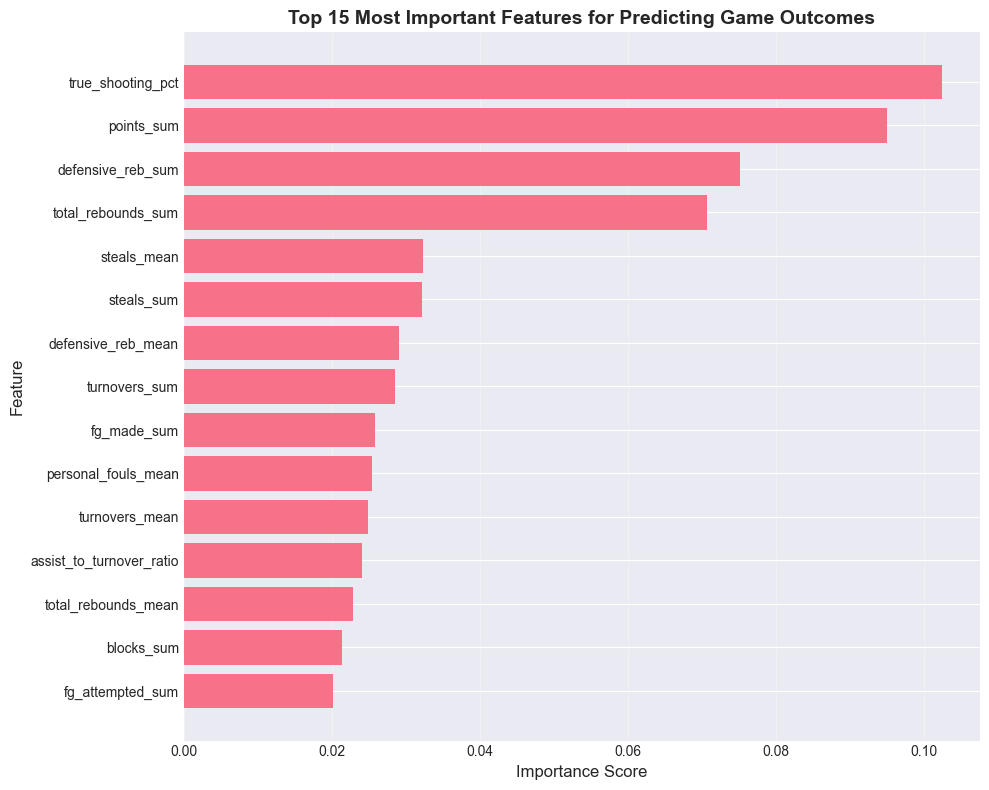

In [23]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 features
print("\nTop 20 Most Important Features:")
print("="*80)
print(feature_importance.head(20).to_string(index=False))

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features for Predicting Game Outcomes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 💾 Save Model and Results

This saves your trained model so you can use it later without retraining.

In [24]:
import joblib
from datetime import datetime

# Create models directory
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)

# Generate filename with timestamp and accuracy
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
accuracy_str = f"{test_accuracy*100:.1f}".replace('.', '_')
model_filename = f"xgboost_model_{timestamp}_acc{accuracy_str}.pkl"
model_path = os.path.join(models_dir, model_filename)

# Save model
joblib.dump(model, model_path)

# Save feature names (important for making predictions later)
feature_names_path = os.path.join(models_dir, 'feature_names.pkl')
joblib.dump(feature_cols, feature_names_path)

# Save results summary
results_summary = {
    'timestamp': timestamp,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'roc_auc': roc_auc,
    'parameters': XGBOOST_PARAMS,
    'train_seasons': TRAIN_SEASONS,
    'test_season': TEST_SEASON,
    'n_features': len(feature_cols),
    'n_training_samples': len(X_train),
    'n_testing_samples': len(X_test)
}

results_path = os.path.join(models_dir, f'results_{timestamp}.json')
import json
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Model and results saved!")
print(f"  Model: {model_path}")
print(f"  Features: {feature_names_path}")
print(f"  Results: {results_path}")

✓ Model and results saved!
  Model: trained_models/xgboost_model_20251123_184028_acc84_3.pkl
  Features: trained_models/feature_names.pkl
  Results: trained_models/results_20251123_184028.json


## 📋 Quick Reference: Parameter Tuning Guide

### If accuracy is too LOW (< 70%):
1. Increase `n_estimators` (try 200, 300)
2. Increase `max_depth` (try 6, 7)
3. Try different `learning_rate` values (0.05, 0.1, 0.2)
4. Decrease `subsample` and `colsample_bytree` (try 0.8, 0.7)

### If model is OVERFITTING (train accuracy >> test accuracy):
1. Decrease `max_depth` (try 3, 4)
2. Increase `min_child_weight` (try 3, 5, 7)
3. Decrease `subsample` (try 0.6, 0.7)
4. Increase `reg_alpha` or `reg_lambda` (try 0.1, 1)
5. Decrease `learning_rate` and increase `n_estimators`

### If training is too SLOW:
1. Decrease `n_estimators`
2. Decrease `max_depth`
3. Increase `learning_rate` (but not too much!)

### Good starting combinations to try:

**Conservative (prevents overfitting):**
```python
n_estimators=200, max_depth=4, learning_rate=0.05, 
min_child_weight=5, subsample=0.8, colsample_bytree=0.8
```

**Balanced (good starting point):**
```python
n_estimators=150, max_depth=5, learning_rate=0.1,
min_child_weight=3, subsample=0.8, colsample_bytree=0.8
```

**Aggressive (higher complexity):**
```python
n_estimators=300, max_depth=7, learning_rate=0.1,
min_child_weight=1, subsample=0.9, colsample_bytree=0.9
```